In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

# Q1

## a. 

#### use cos() for waving time-series, -x/6 for dwindling trend, and normal distribution for noise.

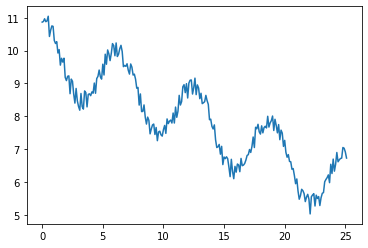

In [58]:
x = np.arange(0,8*np.pi,0.1)   # start,stop,step
y = 10+np.cos(x)-x/6

y_noise = []

for i in y:
    n = 0.3
    noise = np.random.uniform(-n,n)
    y_noise.append(i + noise)

plt.plot(x,y_noise)
plt.show()

## b 

#### period is 3.14, close to 3. 

<ipython-input-59-ab869889bd6c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interger_series['period'] = df_interger_series['period'].div(np.pi).round(1)


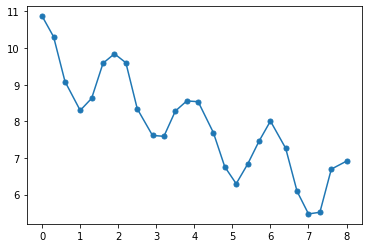

In [59]:
df_original_series = pd.DataFrame({
    'period': x,
    'demand': y_noise
})

# include average interger.
df_interger_series = df_original_series[df_original_series['period'] % 1 == 0]
df_interger_series['period'] = df_interger_series['period'].div(np.pi).round(1)
plt.plot(df_interger_series['period'],df_interger_series['demand'], marker='o',markersize=5)

# deseasonalize
series_deseasonalization = df_interger_series.loc[:, 'demand'].rolling(3).mean().dropna()
series_deseasonalization=series_deseasonalization.drop([series_deseasonalization.index[22],series_deseasonalization.index[23]])

# deseasonalize dataframe
df_deseasonalization = pd.DataFrame({
    'Quater': sum([[1,2,3]*8,[1,2]],[]),
    'Period': df_interger_series['period'] ,
    'Demand': df_interger_series['demand'] ,
    'Deseasonalized_Demand': series_deseasonalization
})

#### translate x axis to # of pi

### c

In [60]:
#build up regressing model
reg = LinearRegression().fit(np.asarray(df_deseasonalization.loc[20:230, 'Period']).reshape(-1, 1),
                            df_deseasonalization.loc[:, 'Deseasonalized_Demand'].dropna())
#predict nan value
values = pd.Series(reg.predict(np.asarray(df_deseasonalization.loc[:, 'Period']).reshape(-1,1)))

df_deseasonalization.loc[0,['Deseasonalized_Demand']] = values[0]
df_deseasonalization.loc[10,['Deseasonalized_Demand']] = values[10]
df_deseasonalization.loc[240,['Deseasonalized_Demand']] = values[24]
df_deseasonalization.loc[250,['Deseasonalized_Demand']] = values[25]

# calculate seansonality factor
df_deseasonalization.loc[:, 'Seasonality'] = (df_deseasonalization.loc[:, 'Demand'] / df_deseasonalization.loc[:, 'Deseasonalized_Demand'])

df_Seasonality_bar= pd.DataFrame({
    'Quater': sum([[1,2,3]*8,[1,2]],[]),
    'Period': df_interger_series['period'] ,
    'Demand': df_interger_series['demand'] ,
    'Deseasonalized_Demand': series_deseasonalization
})

df_seasonality = df_deseasonalization.groupby(['Quater'], as_index=False).mean()
df_seasonality.loc[:, 'Seasonality_bar'] = df_seasonality.loc[:, 'Seasonality']
df_seasonality = df_seasonality[['Quater','Seasonality_bar']]

df_deseasonalization = pd.merge(df_deseasonalization,df_seasonality).sort_values('Period')

In [61]:
df_deseasonalization

,Quater,Period,Demand,Deseasonalized_Demand,Seasonality,Seasonality_bar
0,1,0.0,10.867433,10.022446,1.084310,0.987442
9,2,0.3,10.307763,8.407980,1.225950,1.022739
18,3,0.6,9.086565,10.087254,0.900797,0.979158
1,1,1.0,8.297640,9.230656,0.898922,0.987442
10,2,1.3,8.627718,8.670641,0.995050,1.022739
19,3,1.6,9.585892,8.837084,1.084735,0.979158
2,1,1.9,9.843057,9.352223,1.052483,0.987442
11,2,2.2,9.598873,9.675941,0.992035,1.022739
20,3,2.5,8.340692,9.260874,0.900638,0.979158
3,1,2.9,7.615876,8.518480,0.894042,0.987442


### d 

In [62]:
df_deseasonalization.loc[:, 'Forecast'] =  (reg.predict(np.asarray(df_deseasonalization.loc[:, 'Period']).reshape(-1,1)) * df_deseasonalization.loc[:, 'Seasonality_bar'])
df_deseasonalization.loc[:, 'Error'] =  (df_deseasonalization.loc[:, 'Demand']-df_deseasonalization.loc[:, 'Forecast'])
df_deseasonalization.loc[:, 'Error_Squre'] =  (df_deseasonalization.loc[:, 'Error']*df_deseasonalization.loc[:, 'Error'])
MSE = df_deseasonalization['Error_Squre'].sum()/len(df_deseasonalization)
MAPE = ((abs(df_deseasonalization.loc[:, 'Error']) / abs(df_deseasonalization.loc[:, 'Demand'])).sum())*100/len(df_deseasonalization)

print("MSE:",MSE.round(3))
print("MAPE:",MAPE.round(3))

MSE: 0.523
MAPE: 8.641


### e

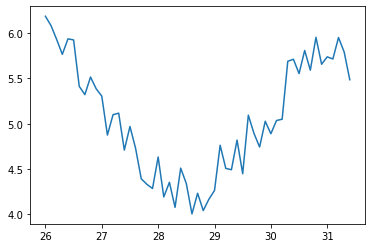

In [63]:
x = np.arange(26.0,10*np.pi,0.1)
y = 10+np.cos(x)-x/6

y_noise = []

for i in y:
    n = 0.3
    noise = np.random.uniform(-n,n)
    y_noise.append(i + noise)
    
plt.plot(x,y_noise)
plt.show()

In [64]:
#true model
df_true_model = pd.DataFrame({
    'Period': x,
    'Demand': y_noise,
    'Forecast':y,
})
df_true_model.loc[:, 'Error'] =  (df_true_model.loc[:, 'Demand']-df_true_model.loc[:, 'Forecast'])
df_true_model.loc[:, 'Error_Squre'] =  (df_true_model.loc[:, 'Error']*df_true_model.loc[:, 'Error'])
MSE = df_true_model['Error_Squre'].sum()/len(df_true_model)
MAPE = ((abs(df_true_model.loc[:, 'Error']) / abs(df_true_model.loc[:, 'Demand'])).sum())*100/len(df_true_model)

print("MSE:",MSE.round(3))
print("MAPE:",MAPE.round(3))

MSE: 0.035
MAPE: 3.28


MSE: 0.513
MAPE: 11.534


<ipython-input-66-45637702f052>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interger_series['Period'] = df_interger_series['Period'].div(np.pi).round(1)


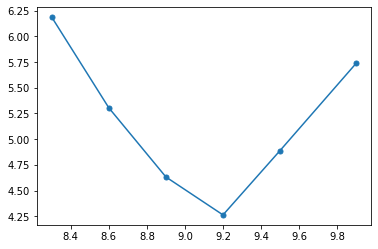

In [66]:
#time-series model
df_time_series_model = pd.DataFrame({   
    'Period': x,
    'Demand': y_noise
})


df_interger_series = df_time_series_model[df_time_series_model['Period'].round(1) % 1.0 == 0]
df_interger_series['Period'] = df_interger_series['Period'].div(np.pi).round(1)
plt.plot(df_interger_series['Period'],df_interger_series['Demand'], marker='o',markersize=5)

df_time_series_deseasonalization= pd.DataFrame({   })
df_time_series_deseasonalization = pd.merge(df_interger_series,df_deseasonalization, how="outer").sort_values('Period')
df_time_series_deseasonalization.loc[:,'Quater']=sum([[1,2,3]*10,[1,2]],[])

df_time_series_deseasonalization=df_time_series_deseasonalization.drop(['Seasonality_bar'], axis=1)
df_time_series_deseasonalization = pd.merge(df_time_series_deseasonalization,df_seasonality,how = "outer").sort_values('Period')

df_time_series_deseasonalization.loc[:, 'Forecast'] =  (reg.predict(np.asarray(df_time_series_deseasonalization.loc[:, 'Period']).reshape(-1,1)) * df_time_series_deseasonalization.loc[:, 'Seasonality_bar'])
df_time_series_deseasonalization.loc[:, 'Error'] =  (df_time_series_deseasonalization.loc[:, 'Demand']-df_time_series_deseasonalization.loc[:, 'Forecast'])
df_time_series_deseasonalization.loc[:, 'Error_Squre'] =  (df_time_series_deseasonalization.loc[:, 'Error']*df_time_series_deseasonalization.loc[:, 'Error'])
MSE = df_time_series_deseasonalization['Error_Squre'].sum()/len(df_time_series_deseasonalization)
MAPE = ((abs(df_time_series_deseasonalization.loc[:, 'Error']) / abs(df_time_series_deseasonalization.loc[:, 'Demand'])).sum())*100/len(df_deseasonalization)

print("MSE:",MSE.round(3))
print("MAPE:",MAPE.round(3))

### f

#### change noise factor to 0.1 only, 3 time less than previous data

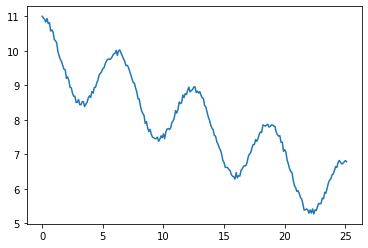

In [67]:
x = np.arange(0,8*np.pi,0.1)   # start,stop,step
y = 10+np.cos(x)-x/6

y_noise = []

for i in y:
    n = 0.1
    noise = np.random.uniform(-n,n)
    y_noise.append(i + noise)

plt.plot(x,y_noise)
plt.show()

<ipython-input-68-ab869889bd6c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interger_series['period'] = df_interger_series['period'].div(np.pi).round(1)


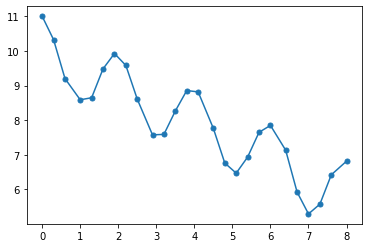

In [68]:
df_original_series = pd.DataFrame({
    'period': x,
    'demand': y_noise
})

# include average interger.
df_interger_series = df_original_series[df_original_series['period'] % 1 == 0]
df_interger_series['period'] = df_interger_series['period'].div(np.pi).round(1)
plt.plot(df_interger_series['period'],df_interger_series['demand'], marker='o',markersize=5)

# deseasonalize
series_deseasonalization = df_interger_series.loc[:, 'demand'].rolling(3).mean().dropna()
series_deseasonalization=series_deseasonalization.drop([series_deseasonalization.index[22],series_deseasonalization.index[23]])

# deseasonalize dataframe
df_deseasonalization = pd.DataFrame({
    'Quater': sum([[1,2,3]*8,[1,2]],[]),
    'Period': df_interger_series['period'] ,
    'Demand': df_interger_series['demand'] ,
    'Deseasonalized_Demand': series_deseasonalization
})

In [69]:
#build up regressing model
reg = LinearRegression().fit(np.asarray(df_deseasonalization.loc[20:230, 'Period']).reshape(-1, 1),
                            df_deseasonalization.loc[:, 'Deseasonalized_Demand'].dropna())
#predict nan value
values = pd.Series(reg.predict(np.asarray(df_deseasonalization.loc[:, 'Period']).reshape(-1,1)))

df_deseasonalization.loc[0,['Deseasonalized_Demand']] = values[0]
df_deseasonalization.loc[10,['Deseasonalized_Demand']] = values[10]
df_deseasonalization.loc[240,['Deseasonalized_Demand']] = values[24]
df_deseasonalization.loc[250,['Deseasonalized_Demand']] = values[25]

# calculate seansonality factor
df_deseasonalization.loc[:, 'Seasonality'] = (df_deseasonalization.loc[:, 'Demand'] / df_deseasonalization.loc[:, 'Deseasonalized_Demand'])

df_Seasonality_bar= pd.DataFrame({
    'Quater': sum([[1,2,3]*8,[1,2]],[]),
    'Period': df_interger_series['period'] ,
    'Demand': df_interger_series['demand'] ,
    'Deseasonalized_Demand': series_deseasonalization
})

df_seasonality = df_deseasonalization.groupby(['Quater'], as_index=False).mean()
df_seasonality.loc[:, 'Seasonality_bar'] = df_seasonality.loc[:, 'Seasonality']
df_seasonality = df_seasonality[['Quater','Seasonality_bar']]

df_deseasonalization = pd.merge(df_deseasonalization,df_seasonality).sort_values('Period')

In [70]:
df_deseasonalization.loc[:, 'Forecast'] =  (reg.predict(np.asarray(df_deseasonalization.loc[:, 'Period']).reshape(-1,1)) * df_deseasonalization.loc[:, 'Seasonality_bar'])
df_deseasonalization.loc[:, 'Error'] =  (df_deseasonalization.loc[:, 'Demand']-df_deseasonalization.loc[:, 'Forecast'])
df_deseasonalization.loc[:, 'Error_Squre'] =  (df_deseasonalization.loc[:, 'Error']*df_deseasonalization.loc[:, 'Error'])
MSE = df_deseasonalization['Error_Squre'].sum()/len(df_deseasonalization)
MAPE = ((abs(df_deseasonalization.loc[:, 'Error']) / abs(df_deseasonalization.loc[:, 'Demand'])).sum())*100/len(df_deseasonalization)

print("MSE:",MSE.round(3))
print("MAPE:",MAPE.round(3))

MSE: 0.515
MAPE: 8.447


#### in this simulation, we have better performance in both MSE and MAPE 

# Q2

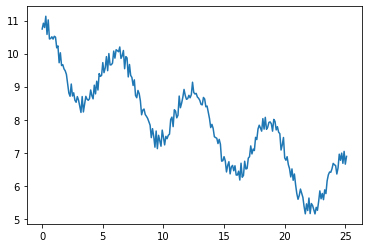

In [71]:
x = np.arange(0,8*np.pi,0.1)   # start,stop,step
y = 10+np.cos(x)-x/6

y_noise = []

for i in y:
    n = 0.3
    noise = np.random.uniform(-n,n)
    y_noise.append(i + noise)

plt.plot(x,y_noise)
plt.show()

<ipython-input-72-bbe5da21f942>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interger_series['Period'] = df_interger_series['Period'].div(np.pi).round(1)


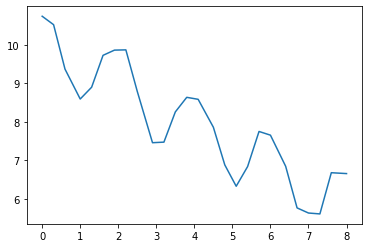

In [72]:
df_original_series = pd.DataFrame({
    'Period': x,
    'Demand': y_noise
})

# include average interger.
df_interger_series = df_original_series[df_original_series['Period'] % 1 == 0]
df_interger_series['Period'] = df_interger_series['Period'].div(np.pi).round(1)
plt.plot(df_interger_series['Period'],df_interger_series['Demand'])


In [73]:
# train the data with Holt-Winters algorithms with statsmodels module.
HWES_model = HWES(df_interger_series.loc[:, 'Demand'], seasonal_periods=8, trend='add', seasonal='mul')
HWES_fit_report = HWES_model.fit()
print(HWES_fit_report.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   Demand   No. Observations:                   26
Model:             ExponentialSmoothing   SSE                             11.221
Optimized:                         True   AIC                              2.152
Trend:                         Additive   BIC                             17.249
Seasonal:                Multiplicative   AICC                            40.334
Seasonal Periods:                     8   Date:                 Sun, 10 Oct 2021
Box-Cox:                          False   Time:                         03:13:49
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

C:\Users\TerryYang\anaconda3\envs\TENSORFLOW\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\TerryYang\anaconda3\envs\TENSORFLOW\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
